In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("hw02.ipynb")

<div class="alert alert-success" markdown="1">

#### Homework 2

# Arrays and DataFrames

### EECS 398-003: Practical Data Science, Fall 2024

#### Due Thursday, September 12th at 11:59PM
    
</div>

## Instructions

Welcome to Homework 2! In this homework, you will practice with `numpy` arrays and `pandas` DataFrames, as we saw in Lectures 3 and 4. See the [Readings section of the Resources tab on the course website](https://practicaldsc.org/resources/#readings) for supplemental resources.

You are given six slip days throughout the semester to extend deadlines. See the [Syllabus](https://practicaldsc.org/syllabus) for more details. With the exception of using slip days, late work will not be accepted unless you have made special arrangements with your instructor.

To access this notebook, you'll need to clone our [public GitHub repository](https://github.com/practicaldsc/fa24/). The [⚙️ Environment Setup](https://practicaldsc.org/env-setup) page on the course website walks you through the necessary steps. Once you're done, you'll submit your completed notebook to Gradescope.

Please start early and submit often. You can submit as many times as you'd like to Gradescope, and we'll grade your **most recent** submission. Remember that the public `grader.check` tests in your notebook are not comprehensive, and that your work will also be graded on hidden test cases on Gradescope after the submission deadline.

This homework is worth a total of **51 points**, 49 of which come from the autograder, **and 2 of which are manually graded by us** (Question 3). The number of points each question is worth is listed at the start of each question. **The three parts of the assignment are independent, so feel free to move around if you get stuck**. Tip: if you're using Jupyter Lab, you can see a Table of Contents for the notebook by going to View > Table of Contents.

To get started, run the **two** import cells below, plus the cell at the top of the notebook that imports and initializes `otter`. The first cell below installs a new package that wasn't included in the `pds` conda environment that we'll need for Part 1.

In [2]:
!pip install networkx

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_inline.backend_inline import set_matplotlib_formats

import plotly
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as pio

# Preferred styles
pio.templates["pds"] = go.layout.Template(
    layout=dict(
        margin=dict(l=30, r=30, t=30, b=30),
        autosize=True,
        width=600,
        height=400,
        xaxis=dict(showgrid=True),
        yaxis=dict(showgrid=True),
        title=dict(x=0.5, xanchor="center"),
    )
)
pio.templates.default = "simple_white+pds"

set_matplotlib_formats("svg")
sns.set_context("poster")
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 5)

# Use plotly as default plotting engine
pd.options.plotting.backend = "plotly"

import networkx as nx

## Part 1: PageRank 🔗

---

In this part of the homework, you'll replicate the PageRank algorithm, the algorithm that Google uses to decide how to rank search results. Along the way, you'll develop proficiency with using arrays in the context of linear algebra.

### Overview

Larry Page and Sergey Brin developed the Google search engine (originally known as "BackRub") while PhD students at Stanford University. Their key innovation was the **PageRank** algorithm. PageRank works by assigning each page on the internet a "score" based on its relative importance. Today, PageRank is one of the many algorithms that Google uses in determining how to rank search results.

We'll give an explanation of the necessary components of PageRank here, but you may also want to refer to these slides, which inspired our exposition: [**The Billion Dollar Eigenvector**](https://jdc.math.uwo.ca/M1600b-2014/l/pagerank-1600.pdf).

**Key idea: The more incoming links a page has, the more important it is!**

<center>

<img src="imgs/network.png" width=300><br><small>An example network of pages.</small>
    
</center>

There are a few naïve approaches to scoring pages given that key idea, but they have their flaws:
- One idea: the score of a page is equal to the number of pages that link to it. This doesn't work because it doesn't account for the importance of the incoming links. For example, if my personal website links to [apple.com](https://apple.com), that doesn't make [apple.com](https://apple.com) any more important than it already was. But if [apple.com](https://apple.com) links to my personal website, that must mean my personal website is important!
- Another idea: The score of a page is equal to the sum of the scores of the pages that link to it. This also doesn't work, because there is no non-zero solution!

The actual solution assigns scores to pages such that **when a page links to several other pages, the score it gives to them is shared**.

In the example graph above, we see that:
- Page 1 links to Page 2.
- Page 2 links to Pages 1 and 4.
- Page 3 links to Pages 1 and 4.
- Page 4 links to Pages 1, 2, and 3.

If we let $x_i$ be the score assigned to Page $i$, we're looking for the solution to the equations:

$$\begin{align*}
x_1 &= &\frac{1}{2}x_2 &+ \frac{1}{2}x_3 &+ \frac{1}{3}x_4 \\
x_2 &= x_1 &&           &+ \frac{1}{3}x_4 \\
x_3 &= &&               & \frac{1}{3}x_4 \\
x_4 &= &\frac{1}{2}x_2 &+ \frac{1}{2}x_3
\end{align*}$$

A more concise way to express the system above is in matrix form, which we can do like so:

$$\vec{x} = A \vec{x}, \qquad A = \begin{bmatrix}
0 & \frac{1}{2} & \frac{1}{2} & \frac{1}{3} \\
1 & 0 & 0 & \frac{1}{3} \\
0 & 0 & 0 & \frac{1}{3} \\
0 & \frac{1}{2} & \frac{1}{2} & 0
\end{bmatrix} \qquad \vec x = \begin{bmatrix} x_1 \\ x_2 \\ x_3 \\ x_4 \end{bmatrix}$$

**Our goal**: Given an adjacency matrix $A$, find the solution to the equation $\vec{x} = A \vec{x}$. We will return to solving this goal in Question 2, but keep it at the back of your mind.

For now, we'll aim to understand the structure of adjacency matrices.
- Each **column** of an adjacency matrix describes the movement **from** a given page; the sums of the columns in an adjacency matrix are equal to 1.
- Each **row** of an adjacency matrix describes the movement **into** a given page; the sums of the rows in an adjacency matrix don't necessarily add to 1.

Below, we've defined a 2D array, `A`, representing $A$ above:

In [4]:
A = np.array([[0, 1 / 2, 1 / 2, 1 / 3],
              [1, 0, 0, 1 / 3],
              [0, 0, 0, 1 / 3],
              [0, 1 / 2, 1 / 2, 0]])
A

array([[0.        , 0.5       , 0.5       , 0.33333333],
       [1.        , 0.        , 0.        , 0.33333333],
       [0.        , 0.        , 0.        , 0.33333333],
       [0.        , 0.5       , 0.5       , 0.        ]])

The function below draws a network given an adjacency matrix. Run the next two cells.

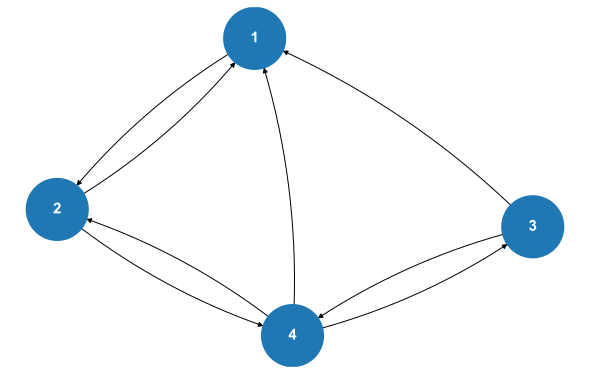

In [5]:
def plot_from_adjacency(adjacency_matrix, node_sizes=0.25):
    np.random.seed(25)
    plt.figure(figsize=(8, 5))
    G = nx.from_numpy_array(adjacency_matrix.T, create_using=nx.DiGraph)
    layout = nx.spring_layout(G)
    labels_dict={i: i+1 for i in range(adjacency_matrix.shape[0])}
    nx.draw(G, layout, 
            node_size=15000 * node_sizes, labels=labels_dict, with_labels=True, font_color='white', font_weight='bold', font_size=15, 
            connectionstyle='arc3, rad = 0.1')
    plt.show()

plot_from_adjacency(A)

Cool!

### Question 1: Creating Adjacency Matrices  <div style="display:inline-block; vertical-align: middle; padding:7px 7px; font-size:10px; font-weight:light; color:white; background-color:#e84c4a; border-radius:7px; text-align:left;">4 Points</div>

Having to specify an adjacency matrix manually is slightly cumbersome. It is more natural and convenient for us to describe the links between webpages using a dictionary. Once such example is as follows:

In [6]:
example_net = {
    1: [2],
    2: [1, 4],
    3: [1, 4],
    4: [1, 2, 3]
}

In the above "network dictionary", we are told that:
- Page 1 links to Page 2.
- Page 2 links to Pages 1 and 4.
- Page 3 links to Pages 1 and 4.
- Page 4 links to Pages 1, 2, and 3.

**Note that this dictionary describes the same network that the adjacency matrix `A` does.**

Below, complete the implementation of the function `create_adjacency`, which takes in a network dictionary, `network` (formatted similarly to `example_net`) and returns the adjacency matrix that corresponds to `network`. Example behavior is given below.

```python
>>> create_adjacency(example_net)
array([[0.        , 0.5       , 0.5       , 0.33333333],
       [1.        , 0.        , 0.        , 0.33333333],
       [0.        , 0.        , 0.        , 0.33333333],
       [0.        , 0.5       , 0.5       , 0.        ]])
```

A few notes:
- It is **not** guaranteed that there are 4 pages in the network. 
- It **is** guaranteed that all pages link to at least one page – potentially itself – and that there is at least one page.
- Remember that adjacency matrices are 1-indexed, like in math, but Python is 0-indexed.

***Hint***: Look into `np.zeros`. You _can_ use a (nested) `for`-loop.

In [7]:
def create_adjacency(network):
    n = max(network.keys())    
    adj_matrix = np.zeros((n, n))
    
    for source, targets in network.items():
        source_idx = source - 1
        for target in targets:
            target_idx = target - 1
            adj_matrix[target_idx, source_idx] = 1 / len(targets)
    
    return adj_matrix

# Feel free to change this input to make sure your function works correctly.
create_adjacency(example_net)

array([[0.        , 0.5       , 0.5       , 0.33333333],
       [1.        , 0.        , 0.        , 0.33333333],
       [0.        , 0.        , 0.        , 0.33333333],
       [0.        , 0.5       , 0.5       , 0.        ]])

In [8]:
grader.check("q01")

q01 results: All test cases passed!

### Question 2: Ranking Pages

Now, back to the task at hand.

**Our goal**: Given an adjacency matrix $A$, find the solution to the equation $\vec{x} = A \vec{x}$. In our example network $A$, the setup looks like:

$$A = \begin{bmatrix}
0 & \frac{1}{2} & \frac{1}{2} & \frac{1}{3} \\
1 & 0 & 0 & \frac{1}{3} \\
0 & 0 & 0 & \frac{1}{3} \\
0 & \frac{1}{2} & \frac{1}{2} & 0
\end{bmatrix} \qquad \vec x = \begin{bmatrix} x_1 \\ x_2 \\ x_3 \\ x_4 \end{bmatrix}$$

How do we find $\vec x$? It turns out that for all valid adjacency matrices, $\vec x$ is an **eigenvector** that corresponds to the **eigenvalue of 1**. Not sure what that means? That's okay – you can learn more about eigen-everything [here](https://youtu.be/PhfbEr2btGQ?si=1diIM4b31qSYrDOZ).

But for our purposes, you don't actually _need_ to know about eigenvalues and eigenvectors. That's because, due to some mathematical theory that's outside of the scope of the course, we can estimate $\vec x$ with great accuracy if we follow the following process:

1. Start by initializing $\vec x^{(0)}$ to a uniform array that sums to 1. This is our initial, or 0th, guess of the true value of $\vec x$. In our example $A$, since $\vec x \in \mathbb{R}^4$, we'd initialize $\vec x^{(0)} = \begin{bmatrix} \frac{1}{4} \\ \frac{1}{4} \\ \frac{1}{4} \\ \frac{1}{4} \end{bmatrix}$. You can imagine this means that a user is equally likely to be on any of the four pages before clicking anything.
1. Simulate the process of the user clicking one link by multiplying $A$ by $\vec x^{(0)}$, and call this $\vec x^{(1)}$, our next guess of the true $\vec x$. In other words, $\vec x^{(1)} = A \vec x^{(0)}$.
2. Repeat this again, so $\vec x^{(2)} = A \vec x^{(1)} = A^2 \vec x^{(0)}$.
3. Repeat many, many times, until the difference between $\vec x^{(i)}$ and $\vec x^{(i-1)}$ is minimal.

Eventually, our guesses $\vec x^{(i)}$ will converge on the true value of $\vec x$, which we can interpret as containing the probability that a user is on any particular page in the long run. **Larger probabilities mean more important pages!**

In short, to estimate $\vec x$, we evaluate $A^{m} \vec x^{(0)}$, where $m$ is some large integer and $x^{(0)}$ is a uniform vector. $m = 100$ is usually sufficient.

Let's work this out concretely with our example adjacency matrix, $A$. Let's initialize `x` to an array of length 4 in which each value is `1 / 4`.

In [9]:
x = np.ones(4) / 4
x

array([0.25, 0.25, 0.25, 0.25])

A better solution than writing:

```python
A @ A @ A @ A @ A @ A @ ... @ x
```

or even:

```python
for i in range(100):
    x = A @ x
```

is using `np.linalg.matrix_power`:

In [10]:
scores = np.linalg.matrix_power(A, 100) @ x
scores

array([0.30769231, 0.38461538, 0.07692308, 0.23076923])

Above are what we call the PageRank scores of each page. Remember, larger scores are more important! This is telling us that:
- Page 2 is the most important,
- then Page 1,
- then Page 4,
- then Page 3.

So, if we were Google, we'd show Page 2 first, then Page 1, then Page 4, then Page 3.

Now it's your turn! We've broken this question up into two smaller parts.

#### Question 2.1: Computing Scores  <div style="display:inline-block; vertical-align: middle; padding:7px 7px; font-size:10px; font-weight:light; color:white; background-color:#e84c4a; border-radius:7px; text-align:left;">2 Points</div>

Complete the implementation of the function `compute_scores`, which takes in an adjacency matrix `matrix` of shape `(n, n)`, where `n` is a positive integer, and returns an array of length `n` containing the PageRank scores of all pages. Compute the PageRank scores using a matrix power of 100, as we did above. Example behavior is given below.

```python
# Remember, compute_scores should work for any adjacency matrix, not just A!
>>> compute_scores(A)
array([0.30769231, 0.38461538, 0.07692308, 0.23076923])
```

In [11]:
def compute_scores(matrix):
    x = np.ones(matrix.shape[0]) / matrix.shape[0]
    return np.linalg.matrix_power(matrix, 100) @ x

# Feel free to change this input to make sure your function works correctly.
compute_scores(A)

array([0.30769231, 0.38461538, 0.07692308, 0.23076923])

In [12]:
grader.check("q02_1")

q02_1 results: All test cases passed!

We can change the sizes of the pages in our network to be proportional to their PageRank scores. To do this, use the `node_sizes` argument in `plot_from_adjacency`.

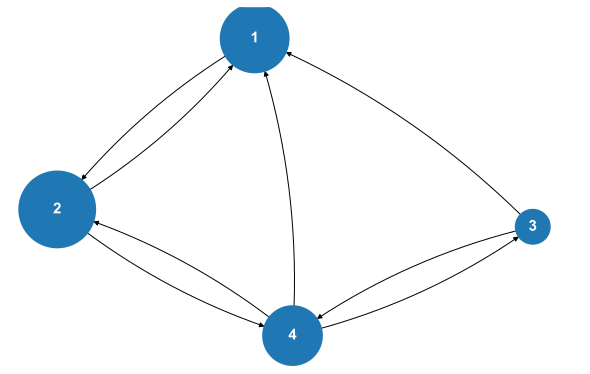

In [13]:
plot_from_adjacency(A, node_sizes=compute_scores(A))

#### Question 2.2: Ranking Pages  <div style="display:inline-block; vertical-align: middle; padding:7px 7px; font-size:10px; font-weight:light; color:white; background-color:#e84c4a; border-radius:7px; text-align:left;">2 Points</div>

Complete the implementation of the function `pagerank`, which takes in an adjacency matrix `matrix` of shape `(n, n)`, where `n` is a positive integer, and returns a list containing the **numbers** of the pages in the matrix, in **decreasing** order of PageRank score as computed by `compute_scores`. If there are ties in scores, return the pages in any order. Example behavior is given below.

```python
>>> pagerank(A)
[2, 1, 4, 3]
```

***Hint:*** Look into `np.argsort`. This should only take 2-3 lines; do not write a `for`-loop.

In [14]:
np.argsort?

Signature:       np.argsort(a, axis=-1, kind=None, order=None)
Call signature:  np.argsort(*args, **kwargs)
Type:            _ArrayFunctionDispatcher
String form:     <function argsort at 0x10af18ee0>
File:            ~/anaconda3/envs/pds/lib/python3.10/site-packages/numpy/core/fromnumeric.py
Docstring:      
Returns the indices that would sort an array.

Perform an indirect sort along the given axis using the algorithm specified
by the `kind` keyword. It returns an array of indices of the same shape as
`a` that index data along the given axis in sorted order.

Parameters
----------
a : array_like
    Array to sort.
axis : int or None, optional
    Axis along which to sort.  The default is -1 (the last axis). If None,
    the flattened array is used.
kind : {'quicksort', 'mergesort', 'heapsort', 'stable'}, optional
    Sorting algorithm. The default is 'quicksort'. Note that both 'stable'
    and 'mergesort' use timsort under the covers and, in general, the
    actual implementation wi

In [15]:
def pagerank(matrix):
    x = np.argsort(-compute_scores(matrix)) 
    return (x + 1).tolist()

# Feel free to change this input to make sure your function works correctly.
pagerank(A)



[2, 1, 4, 3]

In [16]:
grader.check("q02_2")

q02_2 results: All test cases passed!

Once you've completed `pagerank`, run the following cell to try your work .

{1: [6], 2: [1, 3, 4, 6], 3: [2, 5, 6], 4: [1], 5: [1, 2, 6], 6: [2, 4]}


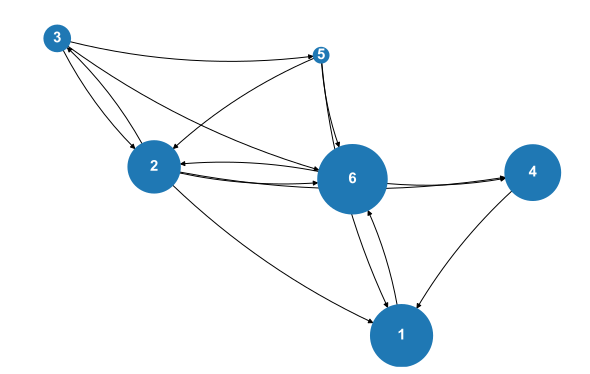

In [17]:
# Here's another example network, which you can use to test your code.
test_net = {1: [6], 2: [1, 3, 4, 6], 3: [2, 5, 6], 4: [1], 5: [1, 2, 6], 6: [2, 4]}
print(test_net)
test_net_adjacency = create_adjacency(test_net)
test_net_scores = compute_scores(test_net_adjacency)
plot_from_adjacency(test_net_adjacency, node_sizes=test_net_scores)

Great work! You've recreated the magic behind Google. (Does this mean you automatically get a job at Google now? Unfortunately, no...)

### Question 3: Sinkholes  <div style="display:inline-block; vertical-align: middle; padding:7px 7px; font-size:10px; font-weight:light; color:white; background-color:#e84c4a; border-radius:7px; text-align:left;">2 Points</div>

Let's wrap up this part of the homework with a puzzle. Consider the following network:

In [18]:
weird_net = {
    1: [1],
    2: [1, 3, 5],
    3: [2, 4],
    4: [1, 2, 3],
    5: [3]
}

Note that Page 1 links to itself and to no other pages. Practically speaking, we can interpret Page 1 as being a "dead end" or "sinkhole", with no outgoing links.

Run the cells below to compute the adjacency matrix and scores for the above network and to visualize it.

[9.99999996e-01 1.35282147e-09 1.59402297e-09 9.64090185e-10
 5.45471812e-10]


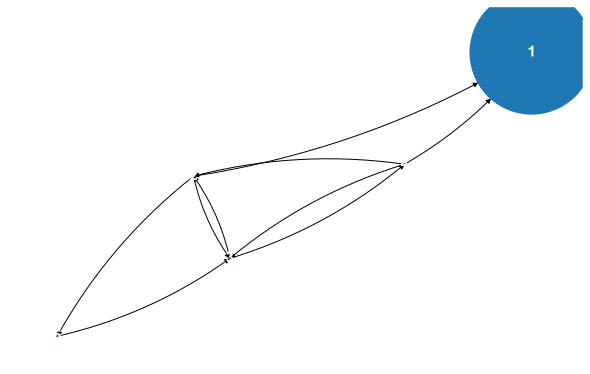

In [19]:
weird_matrix = create_adjacency(weird_net)
weird_scores = compute_scores(weird_matrix)
print(weird_scores)
plot_from_adjacency(weird_matrix, node_sizes=weird_scores)

<!-- BEGIN QUESTION -->

It appears that Page 1's score is 1, and all of the other pages' scores are 0! (`9.6409e-10` means $9.64 \cdot 10^{-10}$, which is a really, really small number.)

<span style="color:red"><b>In the cell below, write your answers to the following two _manually-graded_ prompts.</b></span>

- Why do you think Page 1's score is so high, and the other pages' scores are so low? (***Hint:*** Think about how we interpret the score of a page.)
- Read the [Damping factor](https://en.wikipedia.org/wiki/PageRank#Damping_factor) section of the Wikipedia article on PageRank. In two sentences, describe (to the best of your ability) how using damping would prevent the score of Page 1 from becoming 1. (If you read the article closely, the answer is there – describe it in your own words.)

It's high because it is the only one that links to itself thus giving a score of 1. 
The Damping factor is good because it gives less weight to those that do not link anywhere except to themselves. Thus it is alright. 

<!-- END QUESTION -->

## Part 2: Euchre Returns! 🃏

---

In this part of the homework, we'll practice simulating various probabilities in the context of the popular card game, [Euchre](https://www.wikihow.com/Play-Euchre)!

Euchre, as you may have seen in EECS 280, is a 4-player card game, in which the players are named Player 0, Player 1, Player 2, and Player 3. Euchre is played with a deck of **24 cards**. Each card has two attributes:
- a **suit**, which is either hearts (<span style="color:red">❤️</span>), diamonds (<span style="color:red">♦️</span>), clubs (♣), or spades (♠).
- a **face value**, which is either 9, 10, Jack (J), Queen (Q), King (K), or Ace (A).

The full deck of 24 cards is shown below.

<div align="center">

<span style="color:red">❤️: 9, 10, J, Q, K, A</span><br>
<span style="color:red">♦️: 9, 10, J, Q, K, A</span><br>
<span style="color:black">♣: 9, 10, J, Q, K, A</span><br>
<span style="color:black">♠: 9, 10, J, Q, K, A</span><br>

</center>

The 24 cards are all different. The list `deck`, defined below, represents our deck of 24 cards. Each element in deck is a string representing a card, in the format `'{face} {suit}'`.

Note that you don't need to know how Euchre is played, beyond what is explained above, to work on the following question. (Suraj has never played Euchre before – he's never taken EECS 280 either!)

In [20]:
# Do NOT edit this cell! 
# In our hidden tests, we will assume deck is defined exactly as below.
suits = ['Hearts', 'Diamonds', 'Clubs', 'Spades']
faces = ['9', '10', 'J', 'Q', 'K', 'A']
deck = [f'{face} {suit}' for suit in suits for face in faces]
deck

['9 Hearts',
 '10 Hearts',
 'J Hearts',
 'Q Hearts',
 'K Hearts',
 'A Hearts',
 '9 Diamonds',
 '10 Diamonds',
 'J Diamonds',
 'Q Diamonds',
 'K Diamonds',
 'A Diamonds',
 '9 Clubs',
 '10 Clubs',
 'J Clubs',
 'Q Clubs',
 'K Clubs',
 'A Clubs',
 '9 Spades',
 '10 Spades',
 'J Spades',
 'Q Spades',
 'K Spades',
 'A Spades']

At the start of a round of Euchre, the 24 cards are randomly distributed to the 4 players such that each player gets 5 cards, and the remaining 4 cards ($24 - 5 \cdot 4 = 4$) are put to the side. 

You should use functions built into `np.random` to simulate the act of shuffling and distributing cards. You may find `np.random.choice` and `np.random.permutation` to be useful, but be careful about the arguments you provide and the assumptions they make. You're free to define helper functions to use throughout your work, too – **we did this ourselves** – and you'll need to research various string, list, array, and `np.random` functions and methods to get this all to work.

Your answers will be (very) slightly different than those of your peers, and slightly different each time you run your notebook, due to randomness. This is expected, and our autograder tests will account for this. **Don't** work out the math by hand – that isn't the point of these questions, rather the point is to build your fluency in simulating.

### Question 4: At Least $k$ Same Suit  <div style="display:inline-block; vertical-align: middle; padding:7px 7px; font-size:10px; font-weight:light; color:white; background-color:#e84c4a; border-radius:7px; text-align:left;">5 Points</div>

Complete the implementation of the function `prob_at_least_k_same_suit`, which takes in an integer `k` and returns a simulated estimate of the **probability that Player 0 ends up with at least $k$ cards of the same suit**. Remember, the 24 cards in the Euchre deck (`deck`) are distributed such that Player 0, Player 1, Player 2, and Player 3 each receive 5 cards, and 4 cards are put to the side.

Example behavior is given below.

```python
>>> prob_at_least_k_same_suit(4)
0.02693

# Each time we call prob_at_least_k_same_suit with the same input,
# we should see a slightly different result.
>>> prob_at_least_k_same_suit(4)
0.02591
```

Some extra guidance:
- Use 100,000 repetitions in your simulation.
- If `k` is negative or `0`, return `0`. If `k` is greater than the number of cards given to Player 0, return `0`. (Note that there are some values of `k` for which you'll always end up returning `1` – it's useful to think about which values of `k` these are. Think back to the pigeonhole principle from EECS 203!)
- Look at the default `replace` argument in `np.random.choice` – you may need to set this to something else.

In [21]:
def prob_at_least_k_same_suit(k):
    if k < 1:
        return 0
    elif k == 2:
        return 1
    elif k > 5:
        return 0
    num_simulations = 100000
    success_count = 0
    
    for i in range(num_simulations):
        # Shuffle and deal the cards
        dealt_cards = np.random.choice(deck, size=5, replace=False)
        
        suit_counts = [sum(card.endswith(suit) for card in dealt_cards) for suit in suits]
        
        if any(count == k for count in suit_counts):
            success_count += 1
    
    return success_count / num_simulations
   
    

# Feel free to change this input to make sure your function works correctly.
# Each time you run this cell, you should see a slightly different result!
prob_at_least_k_same_suit(4)

0.02467

In [22]:
grader.check("q04")

q04 results: All test cases passed!

### Question 5: Evenly Distributed Jacks  <div style="display:inline-block; vertical-align: middle; padding:7px 7px; font-size:10px; font-weight:light; color:white; background-color:#e84c4a; border-radius:7px; text-align:left;">5 Points</div>

Complete the implementation of the function `prob_all_one_jack`, which takes no arguments and returns a simulated estimate of the **probability that each player ends up with exactly one Jack (J)**.

Again, use 100,000 repetitions in your simulation.

In [63]:
def prob_all_one_jack():
    num_simulations = 100000
    success_count = 0
    
    for i in range(num_simulations):
        tdeck = deck.copy()
        # Shuffle and deal the cards
        for p in range(4):
            dealt_cards = np.random.choice(tdeck, size=5, replace=False) 
            for card in dealt_cards:
                tdeck.remove(card)
            count = 0 
            for cards in dealt_cards:
                if cards[0] == 'J':
                    count += 1
        if count == 4:
            success_count += 1
    
    return success_count/num_simulations

# Each time you run this cell, you should see a slightly different result!
prob_all_one_jack()

0.00037

In [24]:
grader.check("q05")

q05 results: All test cases passed!

## Part 3: Movies 🎥

---

In this final part of the homework, we'll build our skills in working with DataFrames in `pandas`.


Run the cell below to load in a dataset with information about various movies from [IMDb](https://www.imdb.com/), the Internet Movie Database. (The dataset comes from [Kaggle](https://www.kaggle.com/datasets/parthdande/imdb-dataset-2024-updated)).

In [25]:
imdb = pd.read_csv('data/imdb-2024-cleaned.csv')
imdb

,Title,Year,IMDb Rating,Certificates,Genre,Director,Star Cast,MetaScore,Duration (minutes)
0,10 Things I Hate About You,1999,7.3,PG-13,Comedy,Gil Junger,Heath LedgerJulia StilesJoseph Gordon-Levitt,70.0,97.0
1,12 Angry Men,1957,9.0,Approved,Crime,Sidney Lumet,Reginald Rose,97.0,96.0
2,28 Days Later,2002,7.5,R,Drama,Danny Boyle,Cillian MurphyNaomie HarrisChristopher Eccleston,73.0,113.0
3,A Quiet Place,2018,7.5,PG-13,Drama,John Krasinski,Bryan WoodsScott BeckJohn Krasinski,82.0,90.0
4,A Quiet Place: Day One,2024,7.1,R,Drama,Michael Sarnoski,Michael SarnoskiJohn KrasinskiBryan Woods,66.9,116.3
...,...,...,...,...,...,...,...,...,...
250,Wonka,2023,7.0,PG,Adventure,Paul King,Roald DahlPaul KingSimon Farnaby,66.0,116.0
251,X,2022,6.5,R,Horror,Ti West,Mia GothJenna OrtegaBrittany Snow,80.0,105.0
252,You Can't Run Forever,2024,4.4,R,Drama,Michelle Schumacher,J.K. SimmonsFernanda UrrejolaAllen Leech,66.9,102.0
253,Your Name.,2016,8.4,R,Animation,Makoto Shinkai,Makoto ShinkaiClark Cheng,81.0,116.3


As the preview above shows us, `imdb` has 255 rows, and has some brand new movies, like `'A Quiet Place: Day One'`, released earlier this year.

Not sure what one of the columns means? Google it, as data scientists do – you'll find helpful information directly on IMDb's website.

In lecture, we learned that it's good practice to set the index of a DataFrame to a unique identifier for each row, if one exists. At first glance, it may seem like the values in the `'Title'` column are unique, but upon further investigation we see that there are actually duplicate `'Title'`s:

In [26]:
imdb['Title'].value_counts()

Title
Planet of the Apes            2
The Crow                      2
The Lion King                 2
Dune                          2
10 Things I Hate About You    1
                             ..
Inside Out                    1
Inside Out 2                  1
Interstellar                  1
It                            1
Zootopia                      1
Name: count, Length: 251, dtype: int64

There are 2 rows for `'Planet of the Apes'`, for example. We can query to see just those rows:

In [27]:
imdb[imdb['Title'] == 'Planet of the Apes']

,Title,Year,IMDb Rating,Certificates,Genre,Director,Star Cast,MetaScore,Duration (minutes)
142,Planet of the Apes,1968,8.0,G,Adventure,Franklin J. Schaffner,Michael WilsonRod SerlingPierre Boulle,79.0,112.0
143,Planet of the Apes,2001,5.7,PG-13,Action,Tim Burton,Pierre BoulleWilliam Broyles Jr.Lawrence Konner,50.0,120.0


It seems like there are indeed multiple different `'Planet of the Apes'` movies, released in different years. So, for now, we'll leave the index of `imdb` as-is.

Time to get to work!  Note that all of the following questions are answerable using concepts from [Lecture 4](https://practicaldsc.org/resources/lectures/lec04/lec04-filled.html), though you may find them to be slightly easier after you've gained more practice in Lecture 5.

Important: **DO NOT** modify the `imdb` DataFrame at any point in this notebook! If you do, your code won't be graded correctly when you submit it to Gradescope.

### Question 6: Exploring the Data

In this question, which is made up of 7 smaller subparts, we'll ask you to answer various questions involving the `imdb` DataFrame. **Don't** hard-code your answers; use `pandas` code to find them programatically.

#### Question 6.1: Highest Rating Ever  <div style="display:inline-block; vertical-align: middle; padding:7px 7px; font-size:10px; font-weight:light; color:white; background-color:#e84c4a; border-radius:7px; text-align:left;">1 Point</div>

Assign `highest_rating_ever` to the highest `'IMDb Rating'` of any movie in `imdb`. Your answer should be a float.

In [28]:
highest_rating_ever = imdb.sort_values('IMDb Rating', ascending=False).iloc[0]["IMDb Rating"]
highest_rating_ever

9.2

In [29]:
grader.check("q06_1")

q06_1 results: All test cases passed!

#### Question 6.2: Movie with Highest Rating Ever  <div style="display:inline-block; vertical-align: middle; padding:7px 7px; font-size:10px; font-weight:light; color:white; background-color:#e84c4a; border-radius:7px; text-align:left;">2 Points</div>

Assign `movie_with_highest_rating_ever` to the `'Title'` of the movie with the highest `'IMDb Rating'` of any movie in `imdb`. Assume there are no ties. Your answer should be a string.

In [30]:
movie_with_highest_rating_ever =  imdb.sort_values('IMDb Rating', ascending=False).iloc[0]["Title"]
movie_with_highest_rating_ever

'The Godfather'

In [31]:
grader.check("q06_2")

q06_2 results: All test cases passed!

#### Question 6.3: Comedy Movies  <div style="display:inline-block; vertical-align: middle; padding:7px 7px; font-size:10px; font-weight:light; color:white; background-color:#e84c4a; border-radius:7px; text-align:left;">1 Point</div>

Assign `num_comedy` to the number of movies in `imdb` with a `'Genre'` of `'Comedy'`. Your answer should be an int.

In [32]:
num_comedy = imdb[imdb['Genre'] == 'Comedy'].shape[0]
num_comedy

30

In [33]:
grader.check("q06_3")

q06_3 results: All test cases passed!

#### Question 6.4: Most Common Genre in 2024  <div style="display:inline-block; vertical-align: middle; padding:7px 7px; font-size:10px; font-weight:light; color:white; background-color:#e84c4a; border-radius:7px; text-align:left;">2 Points</div>

Assign `most_common_genre_2024` to the name of the most common `'Genre'` among all movies in `imdb` released in 2024. Assume there are no ties. Your answer should be a string.

In [34]:
most_common_genre_2024 = imdb['Genre'].mode()[0]
most_common_genre_2024

'Action'

In [35]:
grader.check("q06_4")

q06_4 results: All test cases passed!

#### Question 6.5: Big Directors <div style="display:inline-block; vertical-align: middle; padding:7px 7px; font-size:10px; font-weight:light; color:white; background-color:#e84c4a; border-radius:7px; text-align:left;">3 Points</div>

Assign `prop_big_directors` to the **proportion** of movies in `imdb` directed by the top 4 `'Director'`s, when `'Director'`s are ranked by the number of movies they've directed in descending order. Assume that the top 4 `'Directors'` are unambiguous; i.e. that there isn't a 5th director that is tied with one of the top 4. Your answer should be a float between 0 and 1.

In [36]:
prop_big_directors = imdb[imdb['Director'].isin(['Christopher Nolan', 'Quentin Tarantino', 'Martin Scorsese'])].shape[0] / imdb.shape[0]



In [37]:
grader.check("q06_5")

q06_5 results: All test cases passed!

#### Question 6.6: Harry Potter  <div style="display:inline-block; vertical-align: middle; padding:7px 7px; font-size:10px; font-weight:light; color:white; background-color:#e84c4a; border-radius:7px; text-align:left;">2 Points</div>

Assign `average_harry_potter` to the mean `'IMDb Rating'` of all movies with the string `'Harry Potter'` in the `'Title'`. Your answer should be a float.

In [38]:
average_harry_potter = imdb[imdb["Title"].str.contains("Harry Potter") == True]["IMDb Rating"]
average_harry_potter = sum(average_harry_potter) / average_harry_potter.shape[0]
average_harry_potter

7.74

In [39]:
grader.check("q07_6")

q07_6 results: All test cases passed!

#### Question 6.7: Family Friendly  <div style="display:inline-block; vertical-align: middle; padding:7px 7px; font-size:10px; font-weight:light; color:white; background-color:#e84c4a; border-radius:7px; text-align:left;">4 Points</div>

Assign `num_hours_family_friendly` to the number of **hours** it would take you to watch the 10 highest-rated `'PG-13'` movies whose `'Genre'` is either `'Action'` or `'Adventure'`. By highest-rated, we're referring to movies with the highest `'IMDb Rating'`s. Assume that there are no ties in `'IMDb Rating'`s. Your answer should be a float.

In [40]:
#num_hours_family_friendly =  imdb[imdb['Certificates'] == 'PG-13' & (imdb['Genre'] == 'Action') | (imdb['Genre'] == 'Adventure')]
num_hours_family_friendly = imdb[(imdb['Certificates'] == 'PG-13') & 
                                 ((imdb['Genre'] == 'Action') | 
                                  (imdb['Genre'] == 'Adventure'))]
num_hours_family_friendly = num_hours_family_friendly.sort_values('IMDb Rating', ascending=False)
num_hours_family_friendly = num_hours_family_friendly['Duration (minutes)'].head(10).sum() / 60
num_hours_family_friendly

25.9

In [41]:
grader.check("q06_7")

q06_7 results: All test cases passed!

### Question 7: Star Struck

Take a look at the `'Star Cast'` column of `imdb`, which we didn't use in Question 7:

In [42]:
imdb['Star Cast']

0          Heath LedgerJulia StilesJoseph Gordon-Levitt
1                                         Reginald Rose
2      Cillian MurphyNaomie HarrisChristopher Eccleston
3                   Bryan WoodsScott BeckJohn Krasinski
4             Michael SarnoskiJohn KrasinskiBryan Woods
                             ...                       
250                    Roald DahlPaul KingSimon Farnaby
251                   Mia GothJenna OrtegaBrittany Snow
252            J.K. SimmonsFernanda UrrejolaAllen Leech
253                           Makoto ShinkaiClark Cheng
254                    Byron HowardRich MooreJared Bush
Name: Star Cast, Length: 255, dtype: object

Right now, actors' names aren't separated by spaces. With `'Star Cast'` in this form, we can still perform _some_ queries, like looking at all of the movies Margot Robbie was in:

In [43]:
imdb[imdb['Star Cast'].str.contains('Margot Robbie')]

,Title,Year,IMDb Rating,Certificates,Genre,Director,Star Cast,MetaScore,Duration (minutes)
24,Barbie,2023,6.8,PG-13,Adventure,Greta Gerwig,Margot RobbieRyan GoslingIssa Rae,80.0,114.0
140,Once Upon a Time... in Hollywood,2019,7.6,R,Comedy,Quentin Tarantino,Leonardo DiCaprioBrad PittMargot Robbie,84.0,161.0
231,The Wolf of Wall Street,2013,8.2,R,Biography,Martin Scorsese,Leonardo DiCaprioJonah HillMargot Robbie,75.0,180.0


But we **can't** answer questions like, which actor was in the most movies? Let's change that.

#### Question 7.1: Data Cleaning  <div style="display:inline-block; vertical-align: middle; padding:7px 7px; font-size:10px; font-weight:light; color:white; background-color:#e84c4a; border-radius:7px; text-align:left;">5 Points</div>

Complete the implementation of the function `extract_names`, which takes in `s`, a single string formatted like those in the `'Star Cast'` column of `imdb`, and returns a **list** of strings with the names of all of the actors in `s`. Example behavior is given below.

```python
>>> extract_names('Makoto ShinkaiClark Cheng')
['Makoto Shinkai', 'Clark Cheng']

>>> extract_names('Anya Taylor-JoyChris HemsworthTom Burke')
['Anya Taylor-Joy', 'Chris Hemsworth', 'Tom Burke']

>>> extract_names('Santa Ono')
['Santa Ono']
```

For simplicity, you **must** assume that:
- Each actor only has a single first name and a single last name.
- First names and last names are both at least two letters long, contain no spaces, and contain exactly one uppercase letter
- If there is a dash (`'-'`) in an actor's first name or last name, it is not the first or last letter. Dashes are the only non-alphabetic characters that can appear in a first name or last name.

Note that the above assumptions mean that `extract_names` _will_ work incorrectly for cases like the one below; we're adding this simplifying assumption to make your life easier.

```python
>>> extract_names('Leonardo DiCaprioJonah HillMargot Robbie')
['Leonardo Di', 'Caprio', 'Jonah Hill', 'Margot Robbie']
```

Note that the implementation of `extract_names` doesn't involve any `pandas` methods; it's a pure Python problem.

In [44]:
def extract_names(s):
    names = []
    name = ''
    for i in range(len(s)):
        if s[i].isupper() and s[i-1].islower():
            names.append(name)
            name = ''
            name += s[i]
        else:
            name += s[i]
    names.append(name)
    names.pop(0)
    return names

# Feel free to change this input to make sure your function works correctly.
extract_names('Makoto ShinkaiClark Cheng')

['Makoto Shinkai', 'Clark Cheng']

In [45]:
grader.check("q07_1")

q07_1 results: All test cases passed!

Now, using syntax we'll see in Week 3, we've defined for you a Series, named `star_names`, containing the names of all individual actors in `'Star Cast'`. This involves using the Series `apply` method to call your `extract_names` function on every value in `imdb['Star Cast']`, and then combining the resulting lists into one massive list, and finally converting that to Series.

In [46]:
star_names = pd.Series(imdb['Star Cast'].apply(extract_names).sum())
star_names

0              Heath Ledger
1              Julia Stiles
2      Joseph Gordon-Levitt
3             Reginald Rose
4            Cillian Murphy
               ...         
746          Makoto Shinkai
747             Clark Cheng
748            Byron Howard
749              Rich Moore
750              Jared Bush
Length: 751, dtype: object

Note that the values in `star_names` are not unique!

#### Question 7.2: Modes  <div style="display:inline-block; vertical-align: middle; padding:7px 7px; font-size:10px; font-weight:light; color:white; background-color:#e84c4a; border-radius:7px; text-align:left;">2 Points</div>

Complete the implementation of the function `most_common`, which takes in a Series, `ser`, and returns a **list** containing the mode(s) of `ser`. The order of the elements in the returned list does not matter. Assume `ser` contains at least one element. Example behavior is given below.

```python
>>> most_common(pd.Series([1, 2, 2]))
[2]

>>> most_common(pd.Series([1, 2]))
[1, 2]

# This works strangely because of our assumptions in 7.1.
# We're intentionally not showing you the entire output.
>>> star_names_output = most_common(star_names)
>>> 'Caprio' in star_names_output and 'Leonardo Di' in star_names_output
True
```

In [47]:
def most_common(ser):
    return ser.mode().tolist()

# Feel free to change this input to make sure your function works correctly.
most_common(pd.Series([1, 2, 2]))

[2]

In [48]:
grader.check("q07_2")

q07_2 results: All test cases passed!

After you've implemented `most_common`, run the cell below.

In [49]:
most_common(star_names)

['Caprio',
 'Daniel Radcliffe',
 'Emma Watson',
 'Leonardo Di',
 'Pete Docter',
 'Rupert Grint']

You may recognize some of these names, but not others. You should explore! For instance, query `imdb` for all the movies that `'Pete Docter'` starred in. What do you notice?

In [50]:
# You're NOT required to do this, but you should – it's fun!
# BEGIN SOLUTION
imdb[imdb['Star Cast'].str.contains('Pete Docter')]
# END SOLUTION

,Title,Year,IMDb Rating,Certificates,Genre,Director,Star Cast,MetaScore,Duration (minutes)
90,Inside Out,2015,8.1,PG,Animation,Pete Docter,Pete DocterRonnie Del CarmenMeg LeFauve,94.0,95.0
132,"Monsters, Inc.",2001,8.1,G,Animation,Pete Docter,Pete DocterJill CultonJeff Pidgeon,79.0,92.0
233,Toy Story,1995,8.3,G,Animation,John Lasseter,John LasseterPete DocterAndrew Stanton,96.0,81.0
241,Up,2009,8.3,PG,Animation,Pete Docter,Pete DocterBob PetersonTom McCarthy,88.0,96.0
243,WALL·E,2008,8.4,G,Animation,Andrew Stanton,Andrew StantonPete DocterJim Reardon,95.0,98.0


### Question 8: Diving Deeper

To wrap up, let's revisit the larger DataFrame to answer a few more involved questions. Make sure your functions don't make in-place modifications to the input DataFrames!

#### Question 8.1: Longest Title  <div style="display:inline-block; vertical-align: middle; padding:7px 7px; font-size:10px; font-weight:light; color:white; background-color:#e84c4a; border-radius:7px; text-align:left;">3 Points</div>

Complete the implementation of the function `longest_title`, which takes in a DataFrame `df` and returns the longest movie `'Title'`. Assume that `df` has the same 9 column titles as `imdb`, with the same data types, but potentially a different number of rows in a different order, with a potentially different index. Assume that `df` has at least one row, and assume there are no ties. Example behavior is given below.

```python
# Remember, imdb.head(5) is a DataFrame with just the first 5 rows of imdb.
>>> longest_title(imdb.head(5))
'10 Things I Hate About You'
```

In [51]:
def longest_title(df):
    return max(df['Title'], key=len)

# Feel free to change this input to make sure your function works correctly.
longest_title(imdb.head(5))

'10 Things I Hate About You'

In [52]:
grader.check("q08_1")

q08_1 results: All test cases passed!

Once you've implemented `longest_title`, run the cell below to see the longest movie title in `imdb`.

In [53]:
longest_title(imdb)

'The Chronicles of Narnia: The Lion, the Witch and the Wardrobe'

#### Question 8.2: Outliers  <div style="display:inline-block; vertical-align: middle; padding:7px 7px; font-size:10px; font-weight:light; color:white; background-color:#e84c4a; border-radius:7px; text-align:left;">3 Points</div>

Typically, it seems that `'IMDb Rating'`, which are determined by user ratings, and `'MetaScore'` ratings, which are weighted averages of scores given by trusted movie critics, are correlated. That is, movies with high `'IMDb Rating'`s tend to have high `'MetaScore'` ratings, and movies with low `'IMDb Rating'`s tend to have low `'MetaScore'` ratings. We can see this trend in the following scatter plot. Hover over points to see the names of the movies.

In [54]:
imdb.plot(kind='scatter', x='IMDb Rating', y='MetaScore', hover_name='Title', width=800, height=600)

As you can see, there are some outliers, i.e. movies that had relatively high `'MetaScore'`s but relatively low `'IMDb Rating'`s, or vice versa.

We define the `'MetaScore'` to `'IMDb Rating'` ratio of a movie as follows:

$$\frac{\text{Movie's MetaScore}}{\text{Movie's IMDb Rating}}$$

Complete the implementation of the function `metascore_to_rating_outlier`, which takes in a DataFrame `df` and returns the movie with the **largest** `'MetaScore'` to `'IMDb Rating'`. (Note that this is only one of the two types of outliers mentioned in the paragraph at the top of this cell, but use this definition in your solution.)

Assume that `df` has the same 9 column titles as `imdb`, with the same data types, but potentially a different number of rows in a different order, with a potentially different index. Assume that `df` has at least one row, and assume there are no ties. Example behavior is given below.


```python
>>> metascore_to_rating_outlier(imdb.head(5))
'A Quiet Place'
```

In [55]:
def metascore_to_rating_outlier(df):
    meta = np.array(df['MetaScore'])
    Rating = np.array(df['IMDb Rating'])
    final = meta/Rating
    return df.iloc[np.argmax(final)]['Title']

# Feel free to change this input to make sure your function works correctly.
metascore_to_rating_outlier(imdb.head(5))

'A Quiet Place'

In [56]:
grader.check("q08_2")

q08_2 results: All test cases passed!

#### Question 8.3: Recommended For Me <div style="display:inline-block; vertical-align: middle; padding:7px 7px; font-size:10px; font-weight:light; color:white; background-color:#e84c4a; border-radius:7px; text-align:left;">3 Points</div>

And finally, now that you're almost done Homework 2, it's time to find new movies in your favorite genre that the data thinks you might like.

Complete the implementation of the function `genre_specific`, which takes in a DataFrame `df` and a string, `genre`, corresponding to a `'Genre'` in `imdb`. `genre_specific(df, genre)` should return a DataFrame that:
- Contains all of the movies in `df` of `'Genre'` `genre` **released in 2024**. Assume `genre` is a valid value in `df['Genre']`.
- Is sorted in descending order of `'IMDb Rating'`, with ties broken by `'MetaScore'` in descending order. Assume no two movies have both the same `'IMDb Rating'` and the same `'MetaScore'`. (There are a few cases where this happens, but you won't be tested on them in the hidden test cases.)
- Is indexed by `'Title'`, and only has two columns: `'IMDb Rating'` and `'MetaScore'`.

Example behavior is given below.

```python
>>> genre_specific(imdb, 'Horror')
```

<div style="text-align: left;">
  <table border="1" class="dataframe">
    <thead>
      <tr>
        <th style="text-align: left;"></th>
        <th style="text-align: left;">IMDb Rating</th>
        <th style="text-align: left;">MetaScore</th>
      </tr>
      <tr>
        <th>Title</th>
        <th></th>
        <th></th>
      </tr>
    </thead>
    <tbody>
      <tr>
        <th>Alien: Romulus</th>
        <td>7.1</td>
        <td>66.9</td>
      </tr>
      <tr>
        <th>Exhuma</th>
        <td>7.0</td>
        <td>66.9</td>
      </tr>
      <tr>
        <th>The First Omen</th>
        <td>6.7</td>
        <td>65.0</td>
      </tr>
      <tr>
        <th>Abigail</th>
        <td>6.7</td>
        <td>62.0</td>
      </tr>
      <tr>
        <th>Immaculate</th>
        <td>5.8</td>
        <td>57.0</td>
      </tr>
      <tr>
        <th>Sting</th>
        <td>5.7</td>
        <td>57.0</td>
      </tr>
      <tr>
        <th>The Strangers: Chapter 1</th>
        <td>5.0</td>
        <td>43.0</td>
      </tr>
      <tr>
        <th>Tarot</th>
        <td>4.9</td>
        <td>36.0</td>
      </tr>
    </tbody>
  </table>
</div>


In [57]:
def genre_specific(df, genre):
    setid = df.set_index('Title', inplace=False)
    sorted = setid.sort_values(['IMDb Rating','MetaScore'], ascending=False, inplace=False)
    final = sorted[(sorted['Genre'] == genre) & (sorted['Year'] == 2024)]
    final = final[['IMDb Rating', 'MetaScore']].head(8)
    return final

genre_specific(imdb, 'Horror')

,IMDb Rating,MetaScore
Title,,
Alien: Romulus,7.1,66.9
Exhuma,7.0,66.9
The First Omen,6.7,65.0
Abigail,6.7,62.0
Immaculate,5.8,57.0
Sting,5.7,57.0
The Strangers: Chapter 1,5.0,43.0
Tarot,4.9,36.0


<!-- BEGIN QUESTION -->

It appears that Page 1's score is 1, and all of the other pages' scores are 0! (`9.6409e-10` means $9.64 \cdot 10^{-10}$, which is a really, really small number.)

<span style="color:red"><b>In the cell below, write your answers to the following two _manually-graded_ prompts.</b></span>

- Why do you think Page 1's score is so high, and the other pages' scores are so low? (***Hint:*** Think about how we interpret the score of a page.)
- Read the [Damping factor](https://en.wikipedia.org/wiki/PageRank#Damping_factor) section of the Wikipedia article on PageRank. In two sentences, describe (to the best of your ability) how using damping would prevent the score of Page 1 from becoming 1. (If you read the article closely, the answer is there – describe it in your own words.)

Q1. 1's score is so high because page one does not connect to other pages in it's direction. This on it's own may not be the worst case but when we take out matrix and multiply it 100 times with out original wieghts, it makes 1 look like a super important website just becuase "all" (at least the math think so) pages connect to it, but it does not connect to any others. 

Q2. 1 is a sink page. So to avoid 1 seeming Ultra imporant, one way  could be to put an uncharatisticly high damp on it or, teminate the prcess and just start the random surf again as described in the wiki! 


In [58]:
grader.check("q08_3")

q08_3 results: All test cases passed!

## Finish Line 🏁

Congratulations! You're ready to submit Homework 2.

To submit your homework:

1. Select `Kernel -> Restart & Run All` to ensure that you have executed all cells, including the test cells.
2. Read through the notebook to make sure everything is fine and all tests passed.
3. Run the cell below to run all tests, and make sure that they all pass.
4. Download your notebook using `File -> Download as -> Notebook (.ipynb)`, then upload your notebook to Gradescope under "Homework 2".
5. Stick around while the Gradescope autograder grades your work. Make sure you see that all **public tests** have passed on Gradescope. **Remember that homeworks have hidden tests, which you will not see your scores on until a few days after the deadline!**
6. Check that you have a confirmation email from Gradescope and save it as proof of your submission.

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [59]:
grader.check_all()

q01 results: All test cases passed!

q02_1 results: All test cases passed!

q02_2 results: All test cases passed!

q04 results: All test cases passed!

q05 results: All test cases passed!

q06_1 results: All test cases passed!

q06_2 results: All test cases passed!

q06_3 results: All test cases passed!

q06_4 results: All test cases passed!

q06_5 results: All test cases passed!

q06_7 results: All test cases passed!

q07_1 results: All test cases passed!

q07_2 results: All test cases passed!

q07_6 results: All test cases passed!

q08_1 results: All test cases passed!

q08_2 results: All test cases passed!

q08_3 results: All test cases passed!